In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [9]:
def mode(x):
    return stats.mode(x)[0][0]

In [19]:
def etl_pipeline(df, is_train = False, create_interactions = False, fillna_dict = None,\
                 single_interaction_vars = None, higher_interaction_vars = None, df_grouping_train = None):
    df_etl = df.loc[:,:]
    if is_train == True:
        global_filter = (df_etl['return'] < 0.1) & (df_etl['pf_category'] != 'E') & (df_etl['type'] != 'G') & (df_etl['bought'] < 1e10)
        df_etl = df_etl.loc[global_filter, :]
    
    # encode basic variables
    df_etl['indicator_code'] = df_etl['indicator_code'].isnull().apply(lambda x: int(x))
    hedge_value_dict = {True:1, False:0}
    df_etl['hedge_value'] = df_etl['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)
    df_etl['has_desk_id'] = df_etl['desk_id'].isnull().apply(lambda x: int(x))
    
    # create new variables
    df_etl['has_hedge_value'] = df_etl['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
    df_etl['status'] = df_etl['status'].apply(lambda x: 1 if x == True else 0)
    df_etl['sell_year'] = df_etl['sell_date'].apply(lambda x: x//10000)
    df_etl['sell_month'] = df_etl['sell_date'].apply(lambda x: (x//100)%100)
    for col1, col2 in zip(['start_date', 'start_date', 'creation_date'], ['creation_date', 'sell_date', 'sell_date']):
        df_etl[col1 + '_' + col2] = df_etl.apply(lambda row: (datetime.strptime(str(row[col1]), '%Y%m%d') - \
                                                      datetime.strptime(str(row[col2]), '%Y%m%d')).days, axis = 1)
    df_etl['sold_bought'] = df_etl['sold'] - df_etl['bought']
    df_etl['libor_rate_missing'] = df_etl['libor_rate'].isnull().apply(lambda x: int(x))

    # fill missing values
    if fillna_dict is not None:
        df_etl.fillna(fillna_dict, inplace = True)
        
    df_etl['euribor_plus_libor'] = df_etl['euribor_rate'] + df_etl['libor_rate']
    df_etl['euribor_minus_libor'] = df_etl['euribor_rate'] - df_etl['libor_rate']
    
    df_etl['expected_return_start'] = df_etl.apply(lambda row : np.power(row['sold']/row['bought'], -365/row['start_date_sell_date']) - 1\
                                                                if row['start_date_sell_date'] != 0 else -999, axis = 1)
    df_etl['expected_return_creation'] = df_etl.apply(lambda row : np.power(row['sold']/row['bought'], -365/row['creation_date_sell_date']) - 1\
                                                                if row['creation_date_sell_date'] != 0 else -999, axis = 1)
    
    if create_interactions == True and is_train == True:
        assert single_interaction_vars is not None and higher_interaction_vars is not None
        df_grouping = {}
        for var_to_group in single_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby([var_to_group])\
                                              .agg({'return':[np.mean, np.median, np.max, np.min, 'count', np.std, \
                                                              mode]})
            new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            # print (new_col_names)
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

        for var_to_group in higher_interaction_vars:
            print (var_to_group)
            df_grouping[var_to_group] = df_etl.groupby(list(var_to_group))\
                                          .agg({'return':[np.mean, np.median, np.max, np.min, 'count', np.std, \
                                                          mode]})
            new_col_names =  list(var_to_group) + ['_'.join(['_'.join(var_to_group)] + list(x)) \
                              for x in (df_grouping[var_to_group].columns.ravel())]
            df_grouping[var_to_group].reset_index(inplace = True)
            df_grouping[var_to_group].columns = new_col_names
            for col in df_grouping[var_to_group].columns:
                if '_count' in col[-6:]:
                    df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

            df_etl = pd.merge(left = df_etl, right = df_grouping[var_to_group], on = list(var_to_group), how = 'left')
            
    if is_train == False and create_interactions == True:
        assert df_grouping_train is not None
        for var_to_group in df_grouping_train.keys():
            df_etl = pd.merge(left = df_etl, right = df_grouping_train[var_to_group], on = var_to_group, how = 'left')
        
    if is_train == True:
        if (len(df_grouping) > 0):
            return (df_etl, df_grouping)
    return (df_etl)
    

In [20]:
df = pd.read_csv('../inputs/train.csv')
fillna_dict = {'euribor_rate' : df['euribor_rate'].median(),
               'libor_rate' : df['libor_rate'].median(),
               'desk_id' : 'NA',
               'sold' : df['sold'].median(),
               'bought' : df['bought'].median()}
single_interaction_vars = ['pf_category', 'country_code', 'type', 'indicator_code', 'hedge_value',\
                           'status', 'sell_year', 'sell_month']
higher_interaction_vars = [('office_id', 'country_code'), ('pf_category', 'type'), ('office_id', 'type'),\
                           ('office_id', 'pf_category'), ('country_code', 'pf_category')]

In [21]:
df, df_grouping_train = etl_pipeline(df, is_train = True, create_interactions = True, fillna_dict = fillna_dict,\
                                     single_interaction_vars = single_interaction_vars, \
                                     higher_interaction_vars = higher_interaction_vars)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\

['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date', 'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate', 'bought', 'creation_date', 'indicator_code', 'sell_date', 'type', 'hedge_value', 'status', 'return', 'has_desk_id', 'has_hedge_value', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'libor_rate_missing', 'euribor_plus_libor', 'euribor_minus_libor']


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pf_category
country_code
type
indicator_code
hedge_value
status
sell_year
sell_month
('office_id', 'country_code')
('pf_category', 'type')
('office_id', 'type')
('office_id', 'pf_category')
('country_code', 'pf_category')


In [22]:
print (df.dtypes)

portfolio_id                               object
desk_id                                    object
office_id                                  object
pf_category                                object
start_date                                  int64
sold                                      float64
country_code                               object
euribor_rate                              float64
currency                                   object
libor_rate                                float64
bought                                    float64
creation_date                               int64
indicator_code                              int64
sell_date                                   int64
type                                       object
hedge_value                                 int64
status                                      int64
return                                    float64
has_desk_id                                 int64
has_hedge_value                             int64


In [37]:
input_cols_xgb_encode = ['office_id', 'pf_category', 'country_code', 'type'] 
input_cols_xgb_numeric = df.dtypes[(df.dtypes == np.int64) | (df.dtypes == np.float64)].index.tolist()
# print (input_cols_xgb_numeric)
input_cols_xgb_numeric.remove('return')
target_cols_xgb = ['return']

In [38]:
# remove low feature importance columns
low_importance_cols = ['hedge_value_return_count','status_return_amax','status_return_amin','status_return_count','hedge_value_return_amax','indicator_code_return_amin','has_hedge_value','has_desk_id','indicator_code_return_amax','indicator_code_return_median','hedge_value','hedge_value_return_amin','indicator_code_return_count']
low_importance_cols2 = ['type_return_count','pf_category_return_amin','hedge_value_return_mean','country_code_return_count','indicator_code_return_mean','pf_category_return_count','status_return_median','hedge_value_return_median']
low_importance_cols3 = ['country_code_pf_category_return_median','country_code_pf_category_return_amin','status_return_std','office_id_pf_category_return_median','office_id_pf_category_return_mean','office_id_type_return_median','pf_category_return_std','hedge_value_return_median','hedge_value_return_std','libor_rate_missing', 'type_return_std']
low_importance_cols4 = ['country_code_pf_category_return_mean','office_id_country_code_return_mode','office_id_pf_category_return_mode','office_id_pf_category_return_amin','pf_category_return_median','country_code_pf_category_return_mode']
low_importance_cols5 = ['country_code_pf_category_return_amax','office_id_type_return_std','office_id_type_return_mode','country_code_return_amax','office_id_type_return_count','office_id_type_return_amax','office_id_type_return_mean',\
                        'pf_category_type_return_mode','office_id_country_code_return_median','status_return_mode','country_code_return_mode','country_code_pf_category_return_std','indicator_code_return_mode', 'office_id_pf_category_return_std',\
                        'type_return_mode']
low_importance_cols6 = ['pf_category_type_return_amin','office_id_type_return_amin','pf_category_type_return_amax','office_id_pf_category_return_count','indicator_code_return_std','office_id_country_code_return_std','office_id_country_code_return_amin','status_return_mean','hedge_value_return_mode','type_return_median','country_code_return_amin','country_code_return_median','pf_category_return_mode','country_code_pf_category_return_count']
date_cols = ['sell_date', 'creation_date', 'start_date']
different_dist_cols = []
for col in list(low_importance_cols + low_importance_cols2 + low_importance_cols3 + \
                low_importance_cols4 + low_importance_cols5 + low_importance_cols6 + \
                date_cols + different_dist_cols):
    if col in input_cols_xgb_encode:
        input_cols_xgb_encode.remove(col)
    if col in input_cols_xgb_numeric:
        input_cols_xgb_numeric.remove(col)
        
print (input_cols_xgb_numeric)

['sold', 'euribor_rate', 'libor_rate', 'bought', 'indicator_code', 'status', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'euribor_plus_libor', 'euribor_minus_libor', 'expected_return_start', 'expected_return_creation', 'pf_category_return_mean', 'pf_category_return_amax', 'country_code_return_mean', 'country_code_return_std', 'type_return_mean', 'type_return_amax', 'type_return_amin', 'sell_year_return_mean', 'sell_year_return_median', 'sell_year_return_amax', 'sell_year_return_amin', 'sell_year_return_count', 'sell_year_return_std', 'sell_year_return_mode', 'sell_month_return_mean', 'sell_month_return_median', 'sell_month_return_amax', 'sell_month_return_amin', 'sell_month_return_count', 'sell_month_return_std', 'sell_month_return_mode', 'office_id_country_code_return_mean', 'office_id_country_code_return_amax', 'office_id_country_code_return_count', 'pf_category_type_return_mean', 'pf_category_type_return_me

In [39]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    print (input_cols_xgb_encode[i])
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix()

office_id
pf_category
country_code
type


In [14]:
# xgboost parameter tuning

In [46]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [10, 50, 100, 150, 200, 250, 500]}
xgb_reg = XGBRegressor(random_state=42)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'n_estimators': 100}


In [47]:
pd.DataFrame(clf.cv_results_)
# take 200 trees as the optimum number for now

C:\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are acces

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.194000,0.010333,-421.700807,-101.161141,10,{u'n_estimators': 10},7,-50.752442,-164.037567,-92.771971,-77.286165,-1121.802471,-62.159690,0.009416,0.000471,495.264476,44.887165
1,0.567000,0.014000,0.658518,0.964749,50,{u'n_estimators': 50},6,0.586660,0.958354,0.967207,0.965387,0.421612,0.970506,0.002450,0.002160,0.228456,0.004981
2,1.038000,0.015667,0.800800,0.992054,100,{u'n_estimators': 100},1,0.518066,0.998202,0.985303,0.988179,0.899061,0.989783,0.012728,0.000471,0.203015,0.004396
3,1.879333,0.022667,0.766134,0.993762,150,{u'n_estimators': 150},2,0.483715,0.998788,0.985752,0.990668,0.828954,0.991831,0.159157,0.003771,0.209724,0.003585
4,2.078667,0.025333,0.742381,0.994611,200,{u'n_estimators': 200},3,0.466076,0.998988,0.986150,0.991704,0.774929,0.993140,0.076028,0.001247,0.213574,0.003150
5,2.303333,0.028000,0.740850,0.994989,250,{u'n_estimators': 250},4,0.466076,0.998988,0.986184,0.992195,0.770300,0.993783,0.226740,0.005099,0.213363,0.002901
6,4.595667,0.039333,0.718031,0.995891,500,{u'n_estimators': 500},5,0.466076,0.998988,0.987197,0.993706,0.700816,0.994979,0.799350,0.006018,0.213106,0.002251


In [48]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 100)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 3, 'min_child_weight': 1}


In [49]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.106333,0.016000,0.800800,0.992054,3,1,"{u'max_depth': 3, u'min_child_weight': 1}",1,0.518066,0.998202,0.985303,0.988179,0.899061,0.989783,0.030302,0.000817,0.203015,0.004396
1,1.128333,0.015333,0.770605,0.991840,3,3,"{u'max_depth': 3, u'min_child_weight': 3}",5,0.480816,0.997624,0.985583,0.988530,0.845440,0.989367,0.080101,0.004110,0.212765,0.004104
2,1.004667,0.016667,0.739616,0.991200,3,5,"{u'max_depth': 3, u'min_child_weight': 5}",8,0.507856,0.996896,0.984639,0.987577,0.726346,0.989128,0.030346,0.004714,0.194882,0.004077
3,1.444667,0.020000,0.675209,0.996949,5,1,"{u'max_depth': 5, u'min_child_weight': 1}",11,0.371429,0.999173,0.987056,0.995886,0.667138,0.995786,0.071135,0.000000,0.251407,0.001574
4,1.435333,0.014000,0.734192,0.996362,5,3,"{u'max_depth': 5, u'min_child_weight': 3}",9,0.391132,0.998541,0.987009,0.995447,0.824464,0.995098,0.044229,0.012570,0.251511,0.001547
5,1.462000,0.021000,0.758706,0.995738,5,5,"{u'max_depth': 5, u'min_child_weight': 5}",7,0.462575,0.998004,0.987451,0.994422,0.826115,0.994786,0.079402,0.007071,0.219527,0.001609
6,1.819667,0.020667,0.701131,0.998522,7,1,"{u'max_depth': 7, u'min_child_weight': 1}",10,0.394949,0.999476,0.985943,0.998066,0.722509,0.998024,0.238769,0.008014,0.241758,0.000675
7,1.861333,0.016000,0.764115,0.998077,7,3,"{u'max_depth': 7, u'min_child_weight': 3}",6,0.421095,0.999078,0.987447,0.997399,0.883842,0.997754,0.156508,0.000000,0.246231,0.000723
8,1.857667,0.021000,0.781480,0.997422,7,5,"{u'max_depth': 7, u'min_child_weight': 5}",3,0.519659,0.998318,0.986594,0.996757,0.838206,0.997191,0.108739,0.007071,0.194808,0.000658
9,2.251667,0.022000,0.652675,0.999069,9,1,"{u'max_depth': 9, u'min_child_weight': 1}",12,0.459915,0.999601,0.984937,0.998681,0.513127,0.998923,0.397622,0.004243,0.235966,0.000389


In [50]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[2, 3, 4],
 'min_child_weight':[1, 2]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 100)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 3, 'min_child_weight': 1}


In [51]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.748000,0.015667,0.740789,0.986693,2,1,"{u'max_depth': 2, u'min_child_weight': 1}",4,0.499573,0.996668,0.982770,0.981129,0.740024,0.982284,0.012832,0.000471,0.197276,0.007069
1,0.733667,0.021333,0.738953,0.986560,2,2,"{u'max_depth': 2, u'min_child_weight': 2}",5,0.493353,0.996288,0.982945,0.981219,0.740561,0.982173,0.048176,0.007542,0.199889,0.006889
2,1.111667,0.013333,0.800800,0.992054,3,1,"{u'max_depth': 3, u'min_child_weight': 1}",1,0.518066,0.998202,0.985303,0.988179,0.899061,0.989783,0.039263,0.006236,0.203015,0.004396
3,1.039333,0.015333,0.778109,0.991884,3,2,"{u'max_depth': 3, u'min_child_weight': 2}",2,0.503178,0.997904,0.985650,0.988359,0.845520,0.989388,0.027980,0.000471,0.202663,0.004278
4,1.325667,0.017000,0.742913,0.995243,4,1,"{u'max_depth': 4, u'min_child_weight': 1}",3,0.458423,0.998879,0.986643,0.993192,0.783686,0.993658,0.020072,0.000816,0.217574,0.002578
5,1.591333,0.025333,0.694478,0.994960,4,2,"{u'max_depth': 4, u'min_child_weight': 2}",6,0.420671,0.998398,0.986584,0.993030,0.676172,0.993453,0.086785,0.010656,0.231407,0.002437


In [52]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 3, min_child_weight = 1)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'gamma': 0.0}


In [53]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.151667,0.029667,0.742381,0.994611,0,{u'gamma': 0.0},1,0.466076,0.998988,0.986150,0.991704,0.774929,0.993140,0.092856,8.730523e-03,0.213574,0.003150
1,2.049667,0.013000,0.159396,0.865121,0.1,{u'gamma': 0.1},2,-0.174501,0.847854,0.862455,0.854441,-0.209883,0.893068,0.029398,1.414111e-03,0.497387,0.019943
2,1.974000,0.012333,-0.120924,0.774589,0.2,{u'gamma': 0.2},3,-0.397843,0.724378,0.763015,0.774082,-0.728139,0.825307,0.045107,4.714266e-04,0.639468,0.041206
3,1.948667,0.012000,-0.356055,0.709756,0.3,{u'gamma': 0.3},4,-0.571738,0.639021,0.689941,0.712426,-1.186633,0.777822,0.033210,1.123916e-07,0.781123,0.056697
4,1.918667,0.011667,-0.514368,0.654653,0.4,{u'gamma': 0.4},5,-0.578927,0.580078,0.616050,0.651104,-1.580568,0.732776,0.003771,4.713142e-04,0.897903,0.062389
5,1.937333,0.012333,-0.701373,0.597024,0.5,{u'gamma': 0.5},6,-0.589876,0.507629,0.573954,0.612216,-2.088642,0.671228,0.051279,4.714827e-04,1.089827,0.067647


In [54]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'subsample': 0.9, 'colsample_bytree': 0.8}


In [55]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.911667,0.016333,0.767719,0.991014,0.6,0.6,"{u'subsample': 0.6, u'colsample_bytree': 0.6}",15,0.435235,0.997618,0.986623,0.987571,0.881335,0.987852,0.011671,0.000471,0.239017,0.004671
1,0.857667,0.016667,0.774001,0.991240,0.6,0.7,"{u'subsample': 0.7, u'colsample_bytree': 0.6}",14,0.426105,0.997692,0.987340,0.987897,0.908601,0.988131,0.027195,0.000943,0.248110,0.004563
2,0.772333,0.015667,0.759950,0.991612,0.6,0.8,"{u'subsample': 0.8, u'colsample_bytree': 0.6}",17,0.386314,0.997868,0.986498,0.988216,0.907085,0.988754,0.008178,0.000471,0.266203,0.004429
3,0.748333,0.015333,0.787005,0.991851,0.6,0.9,"{u'subsample': 0.9, u'colsample_bytree': 0.6}",8,0.483049,0.997771,0.986789,0.988740,0.891210,0.989043,0.034257,0.000471,0.218459,0.004188
4,0.695667,0.017000,0.791411,0.991406,0.6,1,"{u'subsample': 1.0, u'colsample_bytree': 0.6}",4,0.479424,0.997813,0.987310,0.987704,0.907537,0.988700,0.027980,0.002160,0.223017,0.004549
5,0.991000,0.016333,0.786918,0.990988,0.7,0.6,"{u'subsample': 0.6, u'colsample_bytree': 0.7}",9,0.447514,0.997747,0.985661,0.986707,0.927624,0.988509,0.019799,0.001886,0.241181,0.004836
6,0.912667,0.020000,0.735354,0.991262,0.7,0.7,"{u'subsample': 0.7, u'colsample_bytree': 0.7}",22,0.438008,0.997950,0.985026,0.987334,0.783042,0.988503,0.010209,0.002944,0.225862,0.004753
7,0.878667,0.015667,0.733173,0.992160,0.7,0.8,"{u'subsample': 0.8, u'colsample_bytree': 0.7}",23,0.392331,0.998044,0.986788,0.989264,0.820429,0.989172,0.048307,0.000471,0.250417,0.004161
8,0.881333,0.020667,0.763070,0.992236,0.7,0.9,"{u'subsample': 0.9, u'colsample_bytree': 0.7}",16,0.468298,0.997920,0.985502,0.989351,0.835434,0.989436,0.048196,0.002055,0.217268,0.004019
9,0.853000,0.020667,0.790688,0.991876,0.7,1,"{u'subsample': 1.0, u'colsample_bytree': 0.7}",5,0.483280,0.997980,0.987803,0.988069,0.901017,0.989578,0.009933,0.006600,0.220256,0.004360


In [56]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'subsample':[0.85, 0.9, 0.95],
 'colsample_bytree':[0.75, 0.8, 0.85]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'subsample': 0.85, 'colsample_bytree': 0.85}


In [57]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.892667,0.013333,0.793418,0.991974,0.75,0.85,"{u'subsample': 0.85, u'colsample_bytree': 0.75}",6,0.537770,0.997883,0.986704,0.988548,0.855801,0.989493,0.031962,3.771300e-03,0.188518,0.004195
1,0.912667,0.016000,0.753367,0.992190,0.75,0.9,"{u'subsample': 0.9, u'colsample_bytree': 0.75}",9,0.468861,0.998082,0.986493,0.988746,0.804762,0.989742,0.025197,1.123916e-07,0.214435,0.004186
2,0.822667,0.010667,0.804272,0.992160,0.75,0.95,"{u'subsample': 0.95, u'colsample_bytree': 0.75}",3,0.530590,0.998007,0.985881,0.988829,0.896373,0.989643,0.011785,6.847611e-03,0.196957,0.004148
3,0.910667,0.015000,0.789403,0.992044,0.8,0.85,"{u'subsample': 0.85, u'colsample_bytree': 0.8}",8,0.518398,0.997923,0.987177,0.989168,0.862657,0.989041,0.037650,1.123916e-07,0.198272,0.004157
4,0.895000,0.010667,0.804441,0.992187,0.8,0.9,"{u'subsample': 0.9, u'colsample_bytree': 0.8}",2,0.502758,0.998133,0.986076,0.989028,0.924528,0.989400,0.014306,6.847611e-03,0.214814,0.004207
5,1.025000,0.013000,0.793694,0.992379,0.8,0.95,"{u'subsample': 0.95, u'colsample_bytree': 0.8}",5,0.521238,0.998284,0.985366,0.988907,0.874503,0.989947,0.121647,8.831823e-03,0.197915,0.004197
6,1.047333,0.017667,0.816204,0.991957,0.85,0.85,"{u'subsample': 0.85, u'colsample_bytree': 0.85}",1,0.557160,0.998101,0.986508,0.988268,0.904972,0.989501,0.089340,2.356964e-03,0.186186,0.004374
7,1.200000,0.016333,0.789531,0.992054,0.85,0.9,"{u'subsample': 0.9, u'colsample_bytree': 0.85}",7,0.516910,0.998115,0.986748,0.988442,0.864960,0.989605,0.217196,4.713704e-04,0.199095,0.004312
8,0.961667,0.014333,0.796275,0.992314,0.85,0.95,"{u'subsample': 0.95, u'colsample_bytree': 0.85}",4,0.487522,0.998323,0.986510,0.989256,0.914831,0.989363,0.017594,1.699550e-03,0.220291,0.004249


In [58]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 100, \
                       max_depth = 3, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.85, subsample = 0.85)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'reg_alpha': 1e-05}


In [59]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_reg = XGBRegressor(random_state=42, n_estimators = 1000, \
                       max_depth = 3, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.85, subsample = 0.85, reg_alpha = 1e-5)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'learning_rate': 0.01}


In [95]:
# train the final classifier
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.3, n_estimators = 2000, \
                       max_depth = 7, min_child_weight = 4, gamma = 0, \
                       colsample_bytree = 1.0, subsample = 1.0, reg_alpha = 1e-5)
xgb_reg.fit(X_xgb, y_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [96]:
y_xgb_pred = xgb_reg.predict(X_xgb)
print (r2_score(y_xgb, y_xgb_pred))

0.998804233837


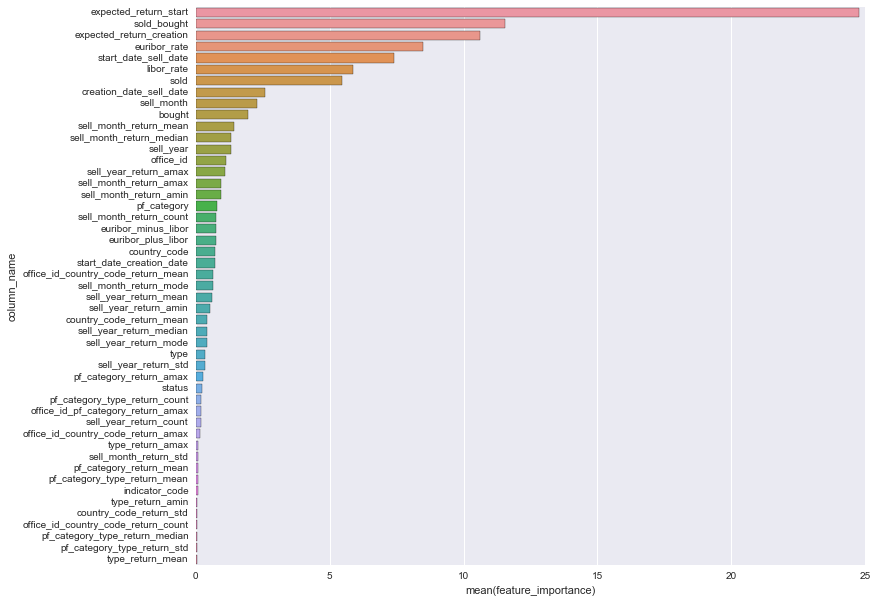

In [97]:
# plot the feature importances
df_feature_importance = pd.DataFrame(list(zip((input_cols_xgb_encode + input_cols_xgb_numeric), \
                                              xgb_reg.feature_importances_)),\
                                     columns = ['column_name', 'feature_importance'])
df_feature_importance = df_feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index()
df_feature_importance['feature_importance'] *= 100
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(12 , 10))
sns.barplot(x = 'feature_importance', y = 'column_name', data = df_feature_importance)

In [98]:
df_feature_importance

,index,column_name,feature_importance
0,18,expected_return_start,24.763258
1,15,sold_bought,11.553030
2,19,expected_return_creation,10.606061
3,5,euribor_rate,8.475379
4,13,start_date_sell_date,7.386363
5,6,libor_rate,5.871212
6,4,sold,5.445076
7,14,creation_date_sell_date,2.604167
8,11,sell_month,2.272727
9,7,bought,1.941288


In [34]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

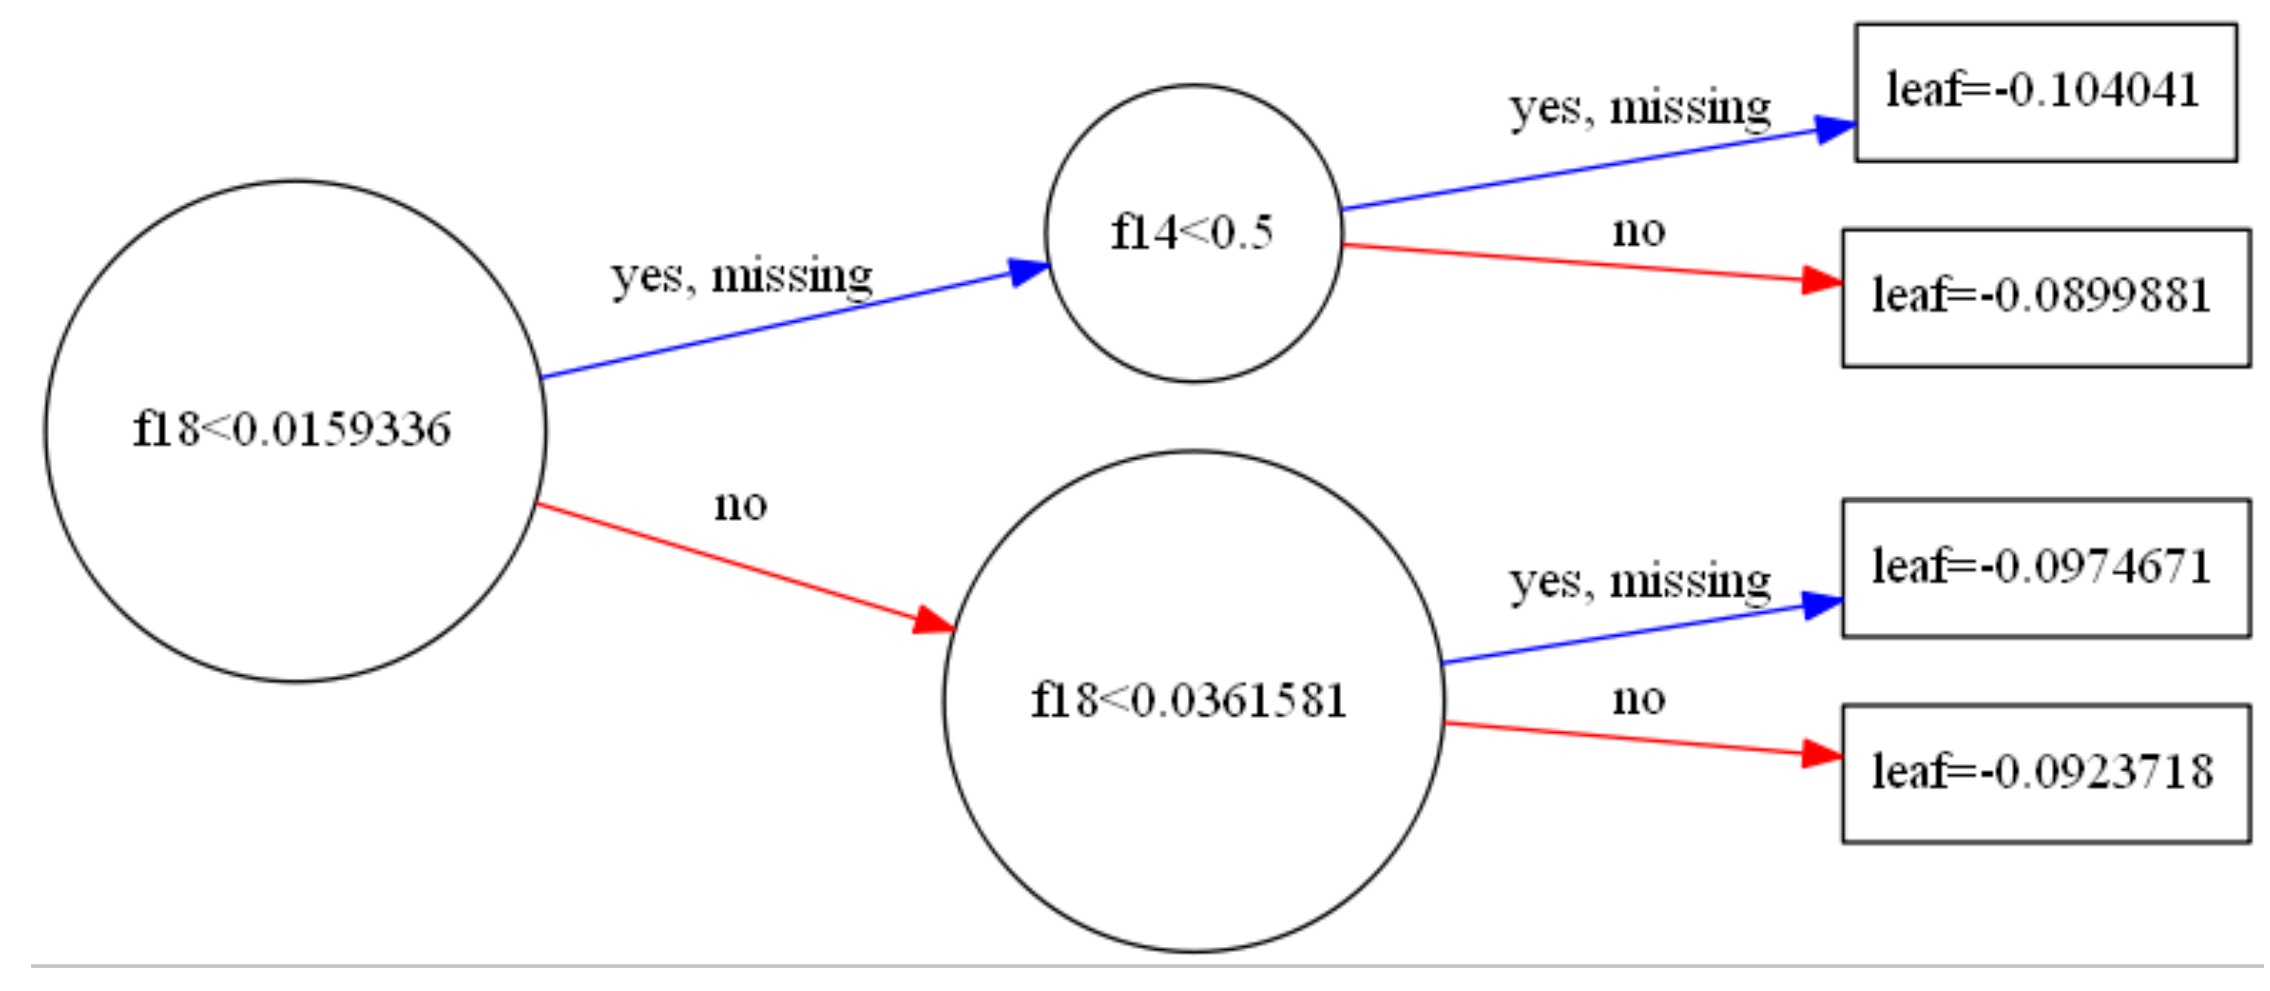

In [99]:
# plot the tree
fig, axs = plt.subplots(nrows = 1, figsize = (40, 20))
plot_tree(xgb_reg, num_trees = 1, rankdir = 'LR', ax = axs)

In [68]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

In [69]:
df_test = etl_pipeline(df_test, is_train=False, create_interactions=True, fillna_dict=fillna_dict,\
                      df_grouping_train=df_grouping_train)

['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date', 'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate', 'bought', 'creation_date', 'indicator_code', 'sell_date', 'type', 'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year', 'sell_month', 'start_date_creation_date', 'start_date_sell_date', 'creation_date_sell_date', 'sold_bought', 'libor_rate_missing', 'euribor_plus_libor', 'euribor_minus_libor']


In [100]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])

df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = xgb_reg.predict(X_xgb_test)

df_submit.to_csv('../submissions/submit_20171218_1727_xgb.csv', index=False)


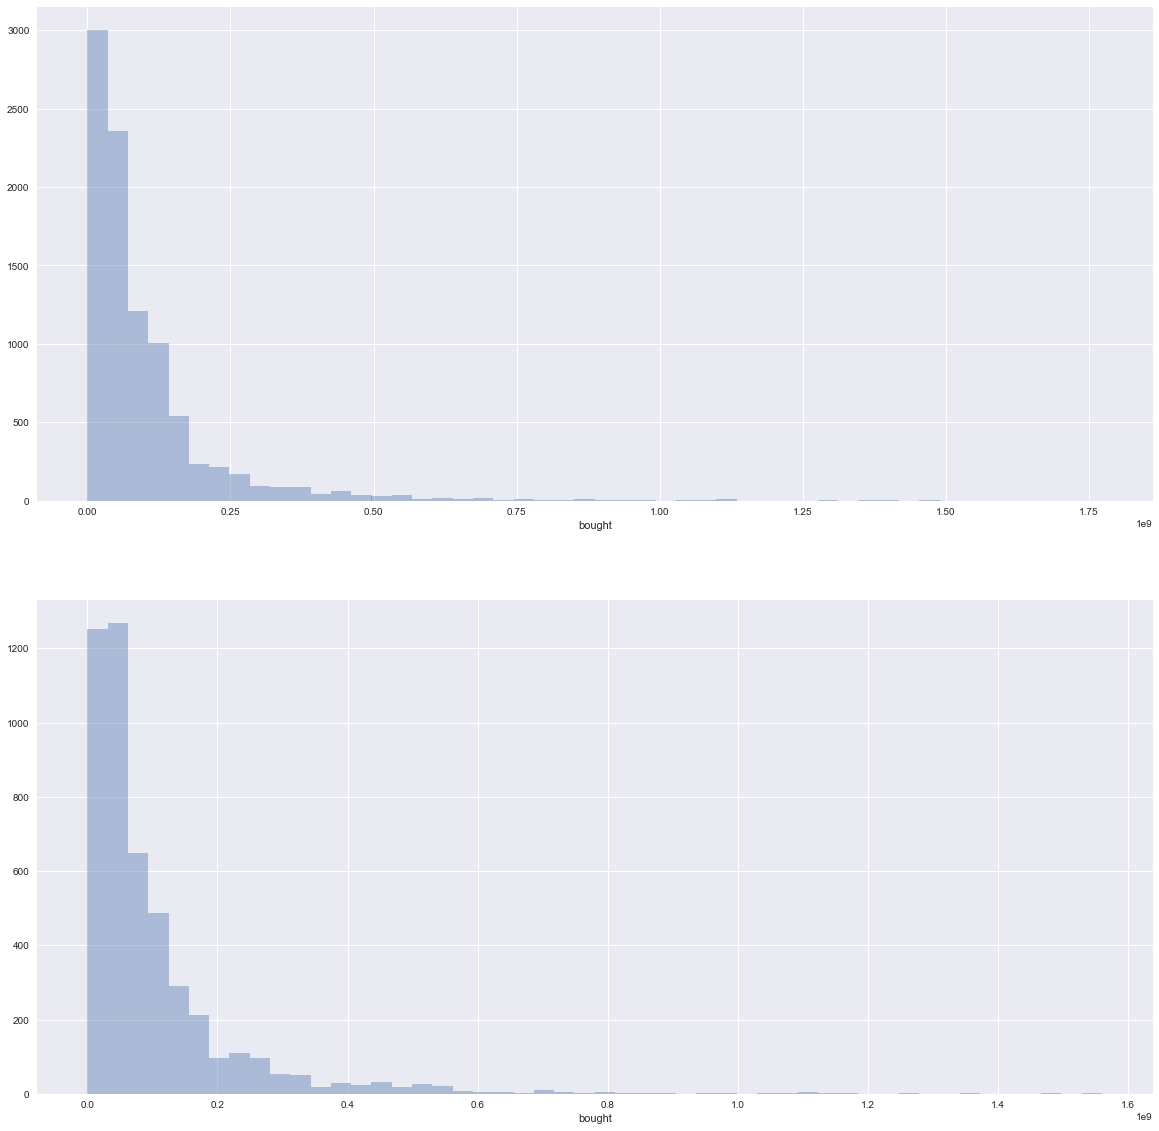

In [41]:
var = 'bought'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df.loc[df['sold_bought'] > -2.5e+5, var], ax = axs[0], kde=False)
sns.distplot(df_test[var], ax = axs[1], kde=False)

In [37]:
print (df['sold_bought'].sort_values().head(10))
print ((df['sold_bought']).describe())
print (df_test['sold_bought'].describe())

7466   -2.602705e+06
8034   -2.180339e+05
7464   -2.093125e+05
8647   -1.351810e+05
9103   -1.307788e+05
8872   -1.265971e+05
8085   -1.004125e+05
7689   -9.842410e+04
7648   -9.178789e+04
7779   -9.061993e+04
Name: sold_bought, dtype: float64
count    9.356000e+03
mean     8.227913e+04
std      2.576593e+05
min     -2.602705e+06
25%      1.805671e+03
50%      8.422815e+03
75%      3.915617e+04
max      3.229342e+06
Name: sold_bought, dtype: float64
count    4.801000e+03
mean     7.775883e+04
std      2.406707e+05
min     -1.952065e+05
25%      1.761696e+03
50%      7.333628e+03
75%      3.652275e+04
max      3.495974e+06
Name: sold_bought, dtype: float64


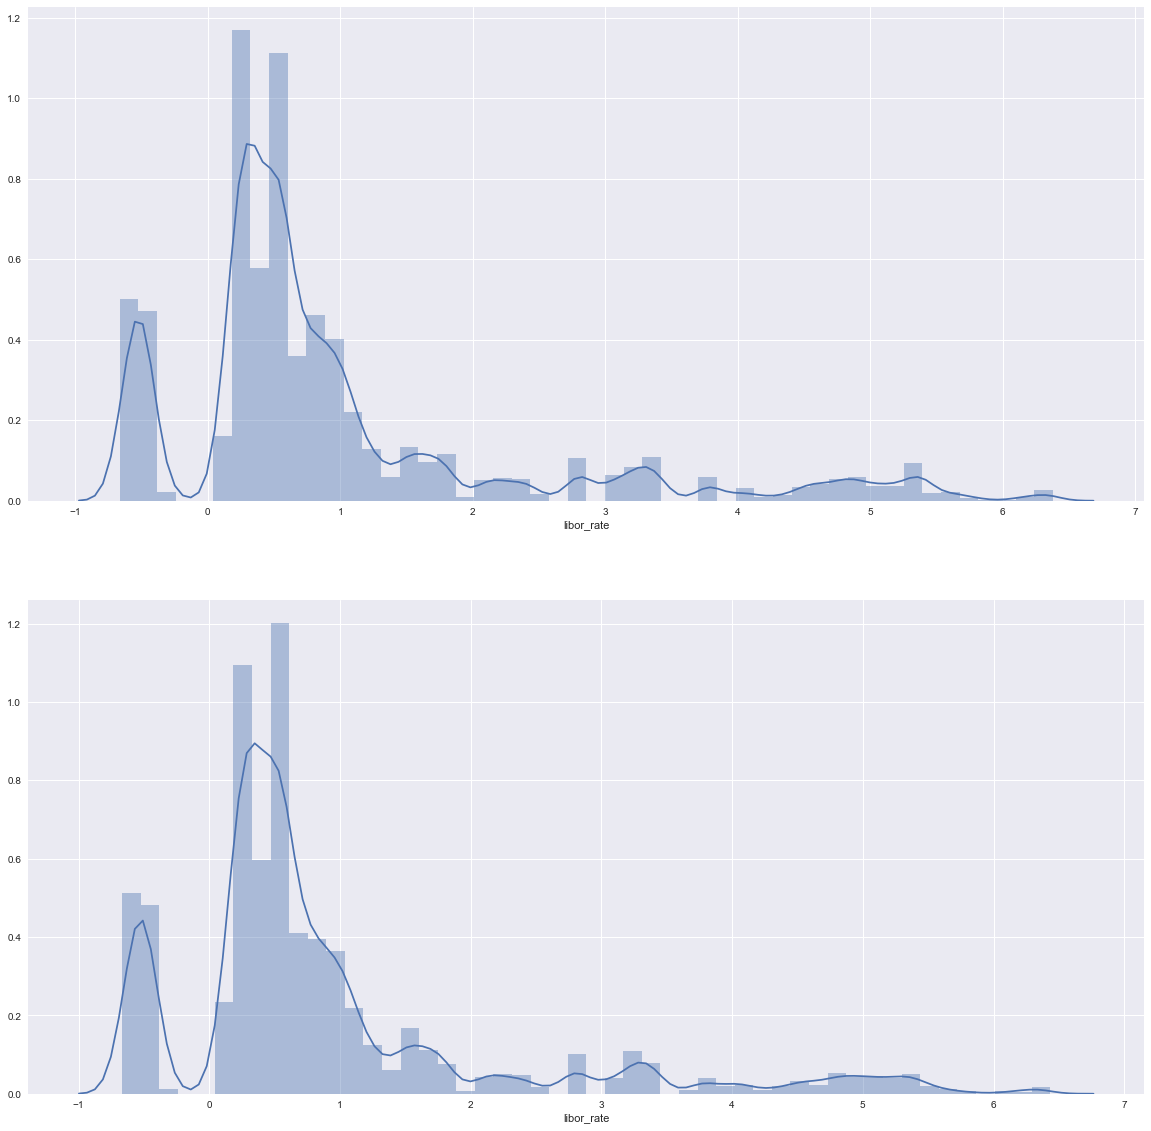

In [151]:
var = 'libor_rate'

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(20 , 20))
sns.distplot(df[var], ax = axs[0])
sns.distplot(df_test[var], ax = axs[1])

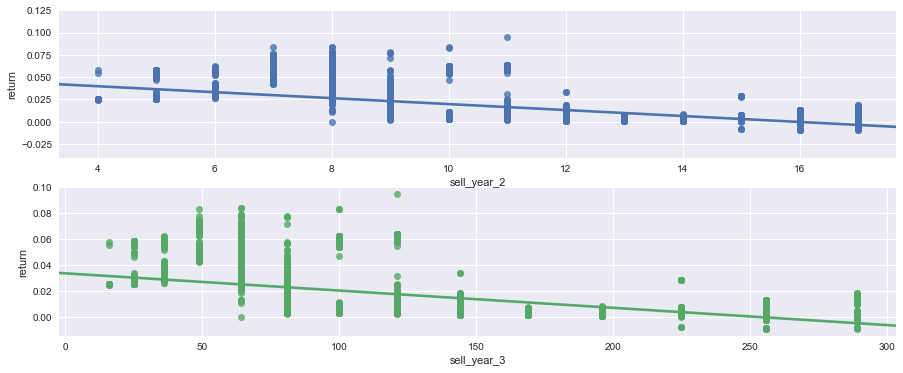

In [45]:
# understand the variation of returns with difference between sell year
variable_considered = 'sell_year'
variable_observed = 'return'
df['sell_year_2'] = df['sell_year'].apply(lambda x: x % 100)
df['sell_year_3'] = df['sell_year_2'].apply(lambda x: x ** 2) 
# fig, axs = plt.subplots(ncols = 3, figsize=(15, 6), gridspec_kw = {'width_ratios':[2, 0.5, 1]})
fig, axs = plt.subplots(nrows = 2, figsize=(15, 6))
sns.regplot(x = 'sell_year_2', y = variable_observed, data = df, ax = axs[0])
sns.regplot(x = 'sell_year_3', y = variable_observed, data = df, ax = axs[1])
# sns.boxplot(y = variable_observed, data = df.loc[filter_condition, :], ax = axs[1])
# sns.countplot(x = variable_considered, data = df.loc[filter_condition, :], ax = axs[2])

In [61]:
for group in df.groupby(['office_id', 'type', 'country_code']):
    print (group[0])

('OFF00001001', 'A', 'T')
('OFF00001001', 'B', 'T')
('OFF00001001', 'C', 'N')
('OFF00001001', 'D', 'M')
('OFF00001001', 'E', 'M')
('OFF00001001', 'E', 'Z')
('OFF00001002', 'B', 'T')
('OFF00001002', 'C', 'N')
('OFF00001002', 'D', 'M')
('OFF00001002', 'E', 'M')
('OFF00001002', 'F', 'U')
('OFF00001002', 'H', 'Z')
